# ML model for Daily Buzz which will help them in predicting rainfall using the given data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the required Libraries

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

## Load the data from the csv files

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Fraud.csv',header=0)

## Data preprocessing

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


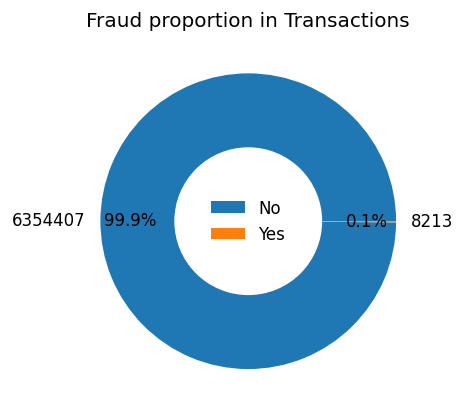

In [6]:
#Checking the proportion of fraudulent transactions within the dataset
donut = df["isFraud"].value_counts().reset_index()

labels = ["No","Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["isFraud"],
        labels=donut["isFraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

In [7]:
#Checking in what type of transactions are the frauds happening
fraud = df[df['isFraud'] == 1]['type'].value_counts().to_frame().reset_index()
fraud.columns = ['Type', 'Count of frauds']
fraud

,Type,Count of frauds
0,CASH_OUT,4116
1,TRANSFER,4097



*   As you can see from the output above the frauds are happening only with cash_out and transfer type of transactions.
*   Count of Cash_out+transfer = 4116+4097= 8213 (The total number of fraudulent transactions within the dataset)

In [8]:
df[df['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


Even the transactions flagged as fraud are also transfer type of transaction making it clear that banks should focus on transfer and cash out type of transaction. Once the banks update the infrastructure we could train the model to focus more on transfer and cash_out transactions and check if the bank is flagging them right.

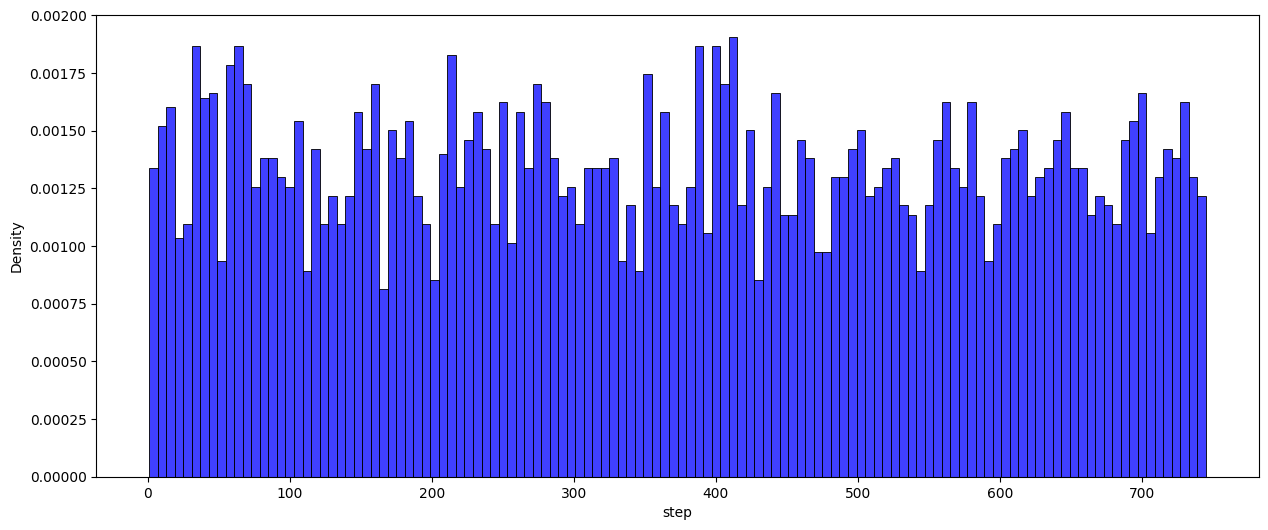

In [9]:
f, ax2= plt.subplots(1, 1, figsize=(15, 6), sharey=True)
ax2 = sns.histplot(x='step', data=df[df["isFraud"] == 1],
                   stat="density", binwidth=6, ax=ax2, color="blue")

The histogram plot above plots the frequency of fraudulent transactions occuring with different time slots. The time slots shown above has a length of 6 hours. Each bin is of the length of 6 hours. The step given in the dataset is of one hour. So out of 744 steps we used a bin width of 6 to plot the distribution of frauds. The plot shows that frauds are not occuring at a particular time.

In [10]:
df.corr()

<ipython-input-10-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [11]:
# Based on the correlation data, we see that the columns cause multi collinearity so to remove it we are dropping the columns
df=df.drop(['newbalanceOrig','newbalanceDest'],axis=1)

The plots below show that certian fields are skewed.Using log q-q plots to show the shewness of the data

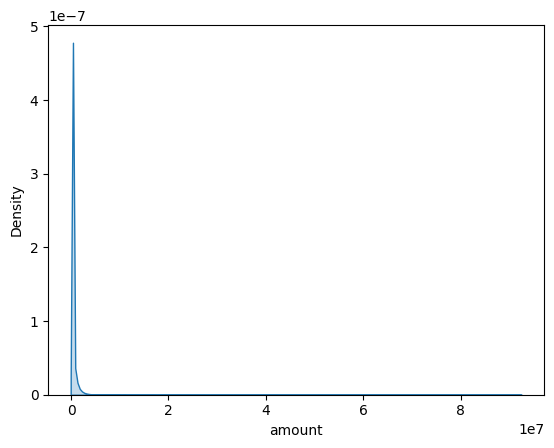

In [12]:
sns.kdeplot(df["amount"], fill=True);

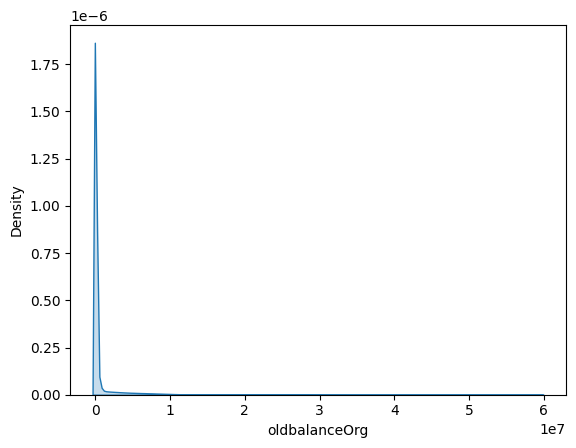

In [13]:
sns.kdeplot(df["oldbalanceOrg"], fill=True);

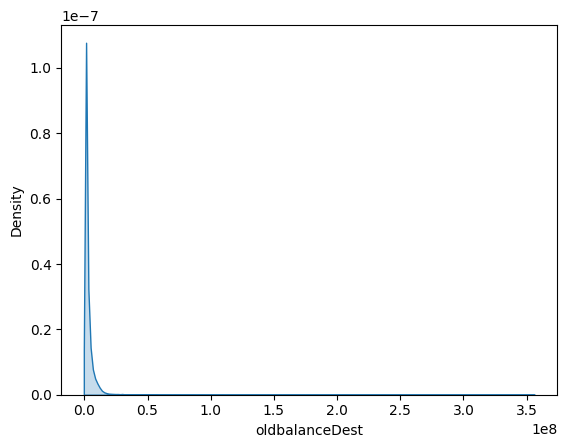

In [14]:
sns.kdeplot(df["oldbalanceDest"], fill=True);

In [15]:
#This function is used to plot the log q-q plots for the data
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(df[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = df[feature].mean()
    std = df[feature].std()
    skew = df[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amount : mean: 179861.90, std: 603858.23, skew: 30.99


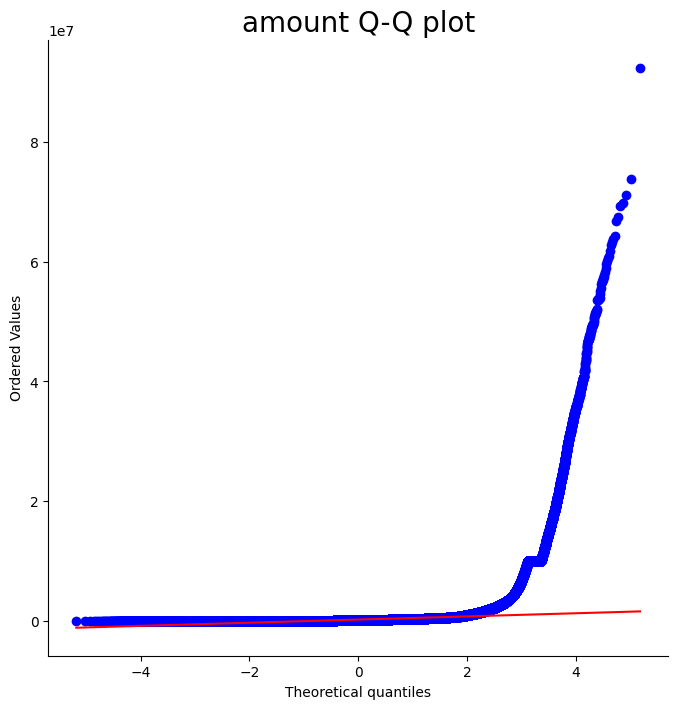

In [16]:
check_normality("amount");

amount_log : mean: 10.84, std: 1.81, skew: -0.56


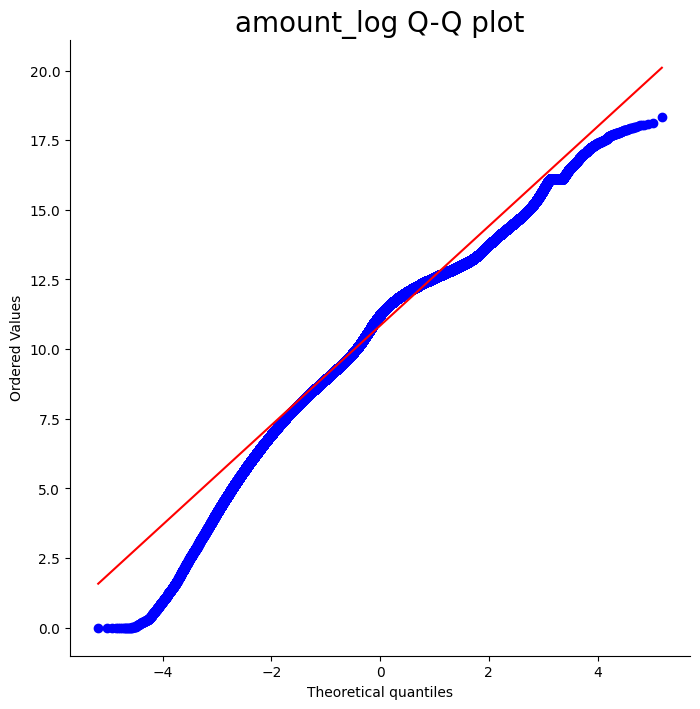

In [17]:
df["amount_log"] = np.log1p(df["amount"]) # Transforming the data by applying log to the data
check_normality("amount_log");

oldbalanceOrg : mean: 833883.10, std: 2888242.67, skew: 5.25


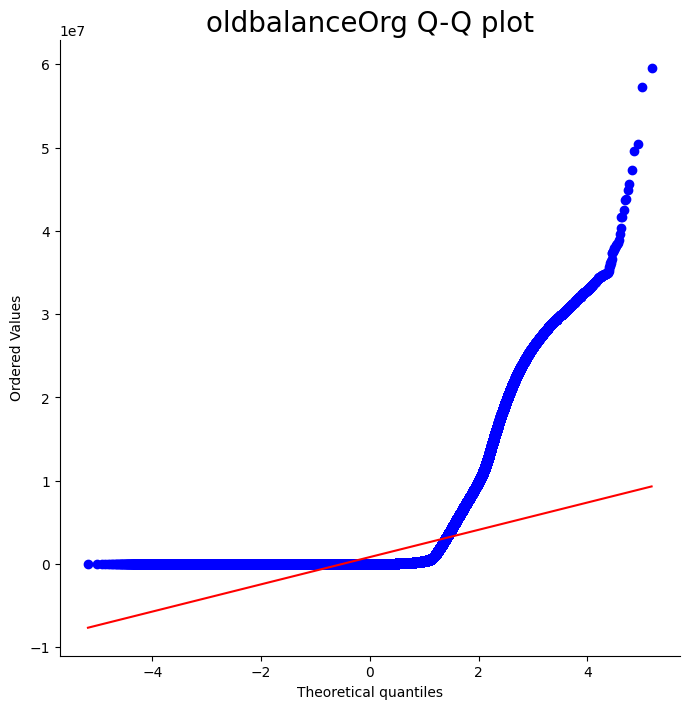

In [18]:
check_normality("oldbalanceOrg");

oldbalanceOrg_log : mean: 7.41, std: 5.67, skew: -0.26


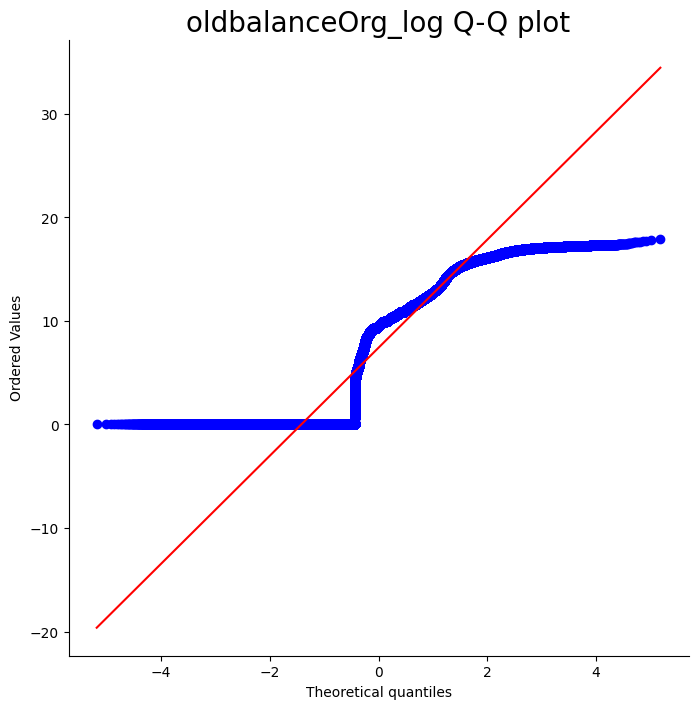

In [19]:
df["oldbalanceOrg_log"] = np.log1p(df["oldbalanceOrg"])# Transforming the data by applying log to the data
check_normality("oldbalanceOrg_log");

oldbalanceDest : mean: 1100701.67, std: 3399180.11, skew: 19.92


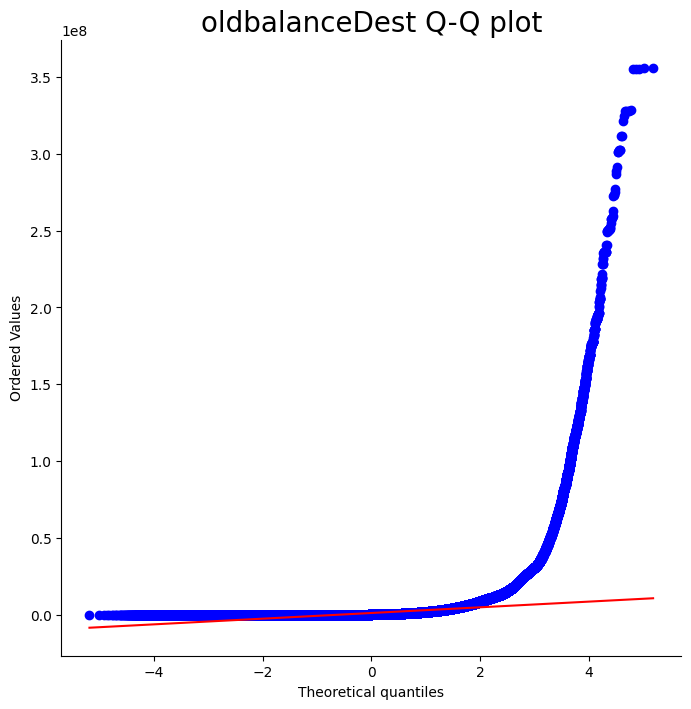

In [20]:
check_normality("oldbalanceDest");

oldbalanceDest_log : mean: 7.72, std: 6.75, skew: -0.21


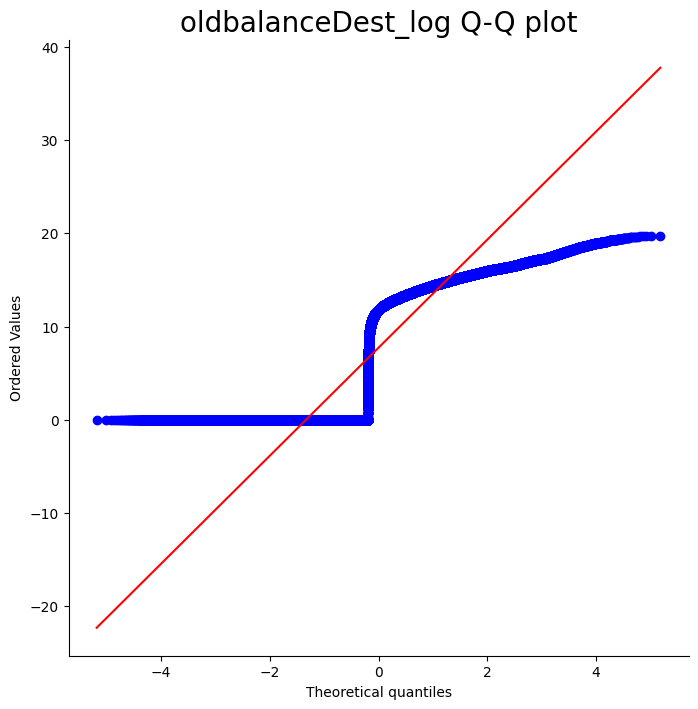

In [21]:
df["oldbalanceDest_log"] = np.log1p(df["oldbalanceDest"])# Transforming the data by applying log to the data
check_normality("oldbalanceDest_log");

In [22]:
df.corr()

<ipython-input-22-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,amount_log,oldbalanceOrg_log,oldbalanceDest_log
step,1.000000,0.022373,-0.010058,0.027665,0.031578,0.003277,0.007377,0.001975,-0.009003
amount,0.022373,1.000000,-0.002762,0.294137,0.076688,0.012295,0.387260,-0.036062,0.182578
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.066243,0.010154,0.003835,0.106980,0.426258,0.232184
oldbalanceDest,0.027665,0.294137,0.066243,1.000000,-0.005885,-0.000513,0.227789,-0.033683,0.367470
isFraud,0.031578,0.076688,0.010154,-0.005885,1.000000,0.044109,0.040640,0.034560,-0.017281
isFlaggedFraud,0.003277,0.012295,0.003835,-0.000513,0.044109,1.000000,0.003604,0.002218,-0.001815
amount_log,0.007377,0.387260,0.106980,0.227789,0.040640,0.003604,1.000000,0.041134,0.612229
oldbalanceOrg_log,0.001975,-0.036062,0.426258,-0.033683,0.034560,0.002218,0.041134,1.000000,0.007651
oldbalanceDest_log,-0.009003,0.182578,0.232184,0.367470,-0.017281,-0.001815,0.612229,0.007651,1.000000


In [23]:
# Dropping categorical columns (nameOrig, nameDest) and numerical columns that has been transformed using log transformations ('oldbalanceOrg','oldbalanceDest')
df=df.drop(['nameOrig','nameDest','amount','oldbalanceOrg','oldbalanceDest'],axis=1)

In [24]:
df=pd.get_dummies(df) # Converting categorical variables into numerical columns

In [25]:
df.head()

,step,isFraud,isFlaggedFraud,amount_log,oldbalanceOrg_log,oldbalanceDest_log,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,0,0,9.194276,12.044359,0.000000,0,0,0,1,0
1,1,0,0,7.531166,9.964112,0.000000,0,0,0,1,0
2,1,1,0,5.204007,5.204007,0.000000,0,0,0,0,1
3,1,1,0,5.204007,5.204007,9.960954,0,1,0,0,0
4,1,0,0,9.364703,10.634773,0.000000,0,0,0,1,0


In [26]:
df.corr()

,step,isFraud,isFlaggedFraud,amount_log,oldbalanceOrg_log,oldbalanceDest_log,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.000000,0.031578,0.003277,0.007377,0.001975,-0.009003,0.004077,-0.012918,0.002869,0.004926,0.006925
isFraud,0.031578,1.000000,0.044109,0.040640,0.034560,-0.017281,-0.019089,0.011256,-0.002911,-0.025697,0.053869
isFlaggedFraud,0.003277,0.044109,1.000000,0.003604,0.002218,-0.001815,-0.000842,-0.001168,-0.000128,-0.001133,0.005245
amount_log,0.007377,0.040640,0.003604,1.000000,0.041134,0.612229,0.236138,0.340431,-0.130937,-0.735818,0.354745
oldbalanceOrg_log,0.001975,0.034560,0.002218,0.041134,1.000000,0.007651,0.510939,-0.261311,0.015788,-0.102865,-0.142448
oldbalanceDest_log,-0.009003,-0.017281,-0.001815,0.612229,0.007651,1.000000,0.324141,0.402526,0.062254,-0.818037,0.200450
type_CASH_IN,0.004077,-0.019089,-0.000842,0.236138,0.510939,0.324141,1.000000,-0.391047,-0.042987,-0.379522,-0.160535
type_CASH_OUT,-0.012918,0.011256,-0.001168,0.340431,-0.261311,0.402526,-0.391047,1.000000,-0.059625,-0.526422,-0.222672
type_DEBIT,0.002869,-0.002911,-0.000128,-0.130937,0.015788,0.062254,-0.042987,-0.059625,1.000000,-0.057868,-0.024478
type_PAYMENT,0.004926,-0.025697,-0.001133,-0.735818,-0.102865,-0.818037,-0.379522,-0.526422,-0.057868,1.000000,-0.216110


In [27]:
# removing this because for categorical column with five categories four columns are enough.Also the below column was causing multi collinearity
df=df.drop(['type_PAYMENT'],axis=1)

In [28]:
# Creating X and Y variables to train and test the model
X = df.drop(columns=["isFraud"])
y = df["isFraud"]

In [29]:
X.head()

,step,isFlaggedFraud,amount_log,oldbalanceOrg_log,oldbalanceDest_log,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_TRANSFER
0,1,0,9.194276,12.044359,0.000000,0,0,0,0
1,1,0,7.531166,9.964112,0.000000,0,0,0,0
2,1,0,5.204007,5.204007,0.000000,0,0,0,1
3,1,0,5.204007,5.204007,9.960954,0,1,0,0
4,1,0,9.364703,10.634773,0.000000,0,0,0,0


In [30]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

## Undersampling

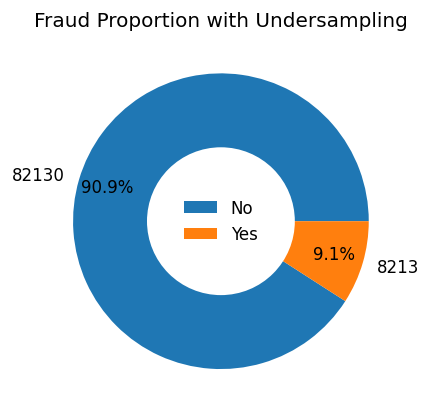

In [57]:
# The data is highly unbalanced so using under sampling to better train models
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)
X_undersampled, y_undersampled = rus.fit_resample(X, y)
donut = y_undersampled.value_counts().reset_index()
labels = ["No", "Yes"]
explode = (0, 0)
fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["isFraud"],
        labels=donut["isFraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)
centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

## Oversampling

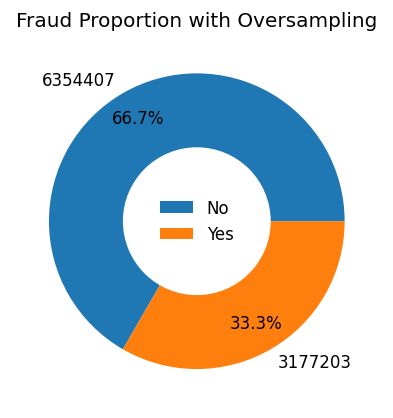

In [84]:
# The data is highly unbalanced so also trying over sampling to better train models
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.5,random_state=23)
X_oversampled, y_oversampled = ros.fit_resample(X, y)
donut = y_oversampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["isFraud"],
        labels=donut["isFraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Oversampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

In [86]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72274, 9) (18069, 9) (72274,) (18069,)


In [47]:
# This function can plot the importance of the features utllized by the model
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')


In [66]:
# Evaluate the performance of the models using confusion matrix, precision, accuracy,recall,f1 score, and AUC
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None


In [89]:
# The models tested for the task given
import xgboost as xgb
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
xgb=xgb.XGBClassifier(random_state=23)
adb=AdaBoostClassifier(random_state=23)

##Random Forest model with undersampled dataset

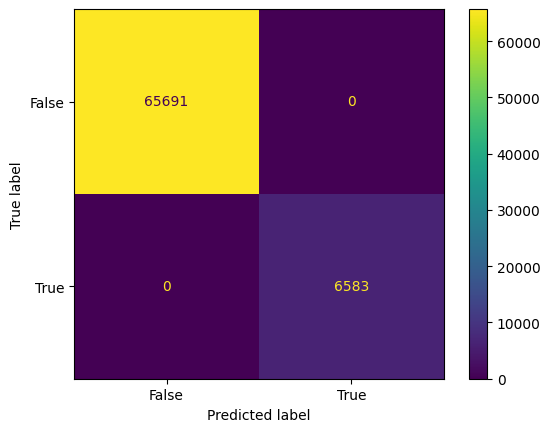

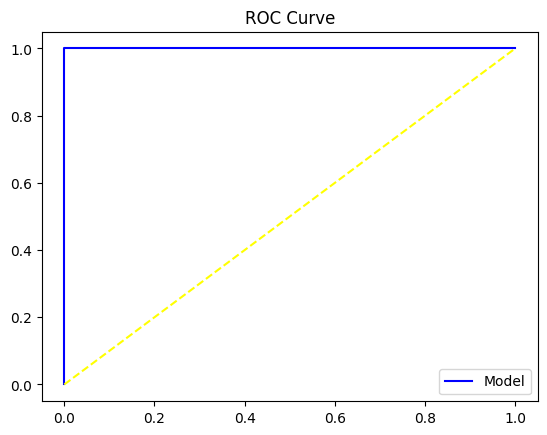

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [69]:
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]
evaluate_model(y_train, y_pred_train, y_score_train)# performance with train data

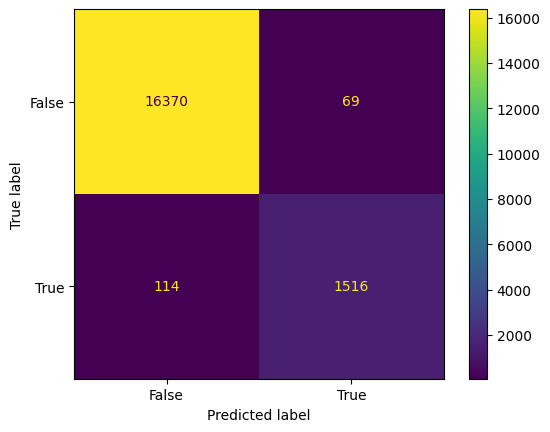

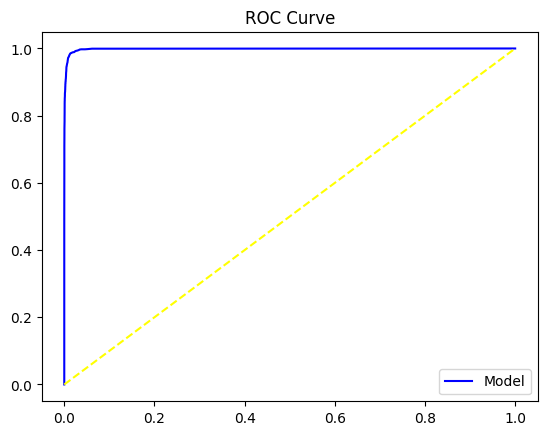

Accuracy 0.99
Precision: 0.96
Recall: 0.93
F1 Score 0.94
AUC: 0.9985493124423179


In [70]:
evaluate_model(y_test, y_pred_test, y_score_test) # performance with test data

##K Nearest Neighbours model with undersampled dataset

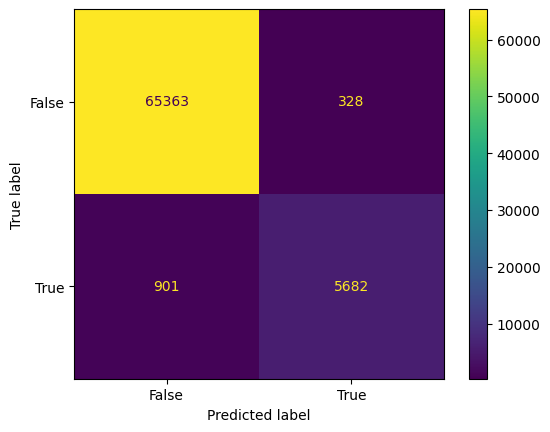

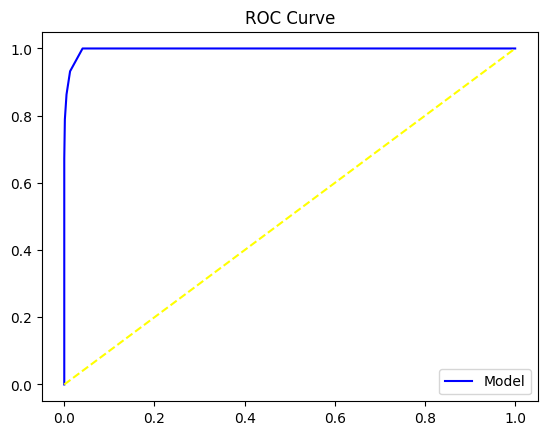

Accuracy 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.9
AUC: 0.9972576370509768


In [71]:
knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]
evaluate_model(y_train, y_pred_train, y_score_train)# performance with train data

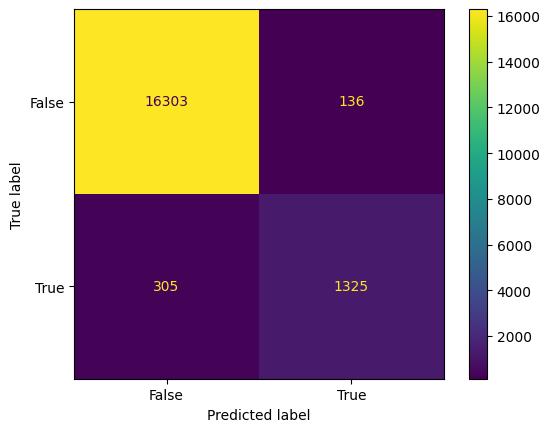

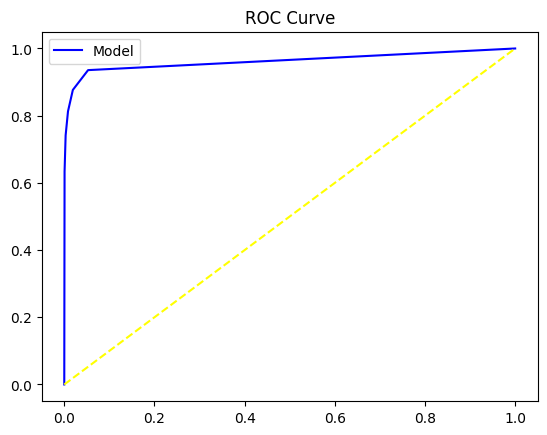

Accuracy 0.98
Precision: 0.91
Recall: 0.81
F1 Score 0.86
AUC: 0.9622888783481748


In [72]:
evaluate_model(y_test, y_pred_test, y_score_test)# performance with test data

##Gradient Boosting Decision tree model with undersampled dataset

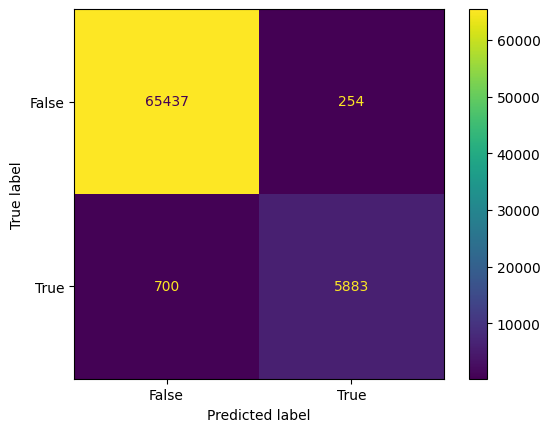

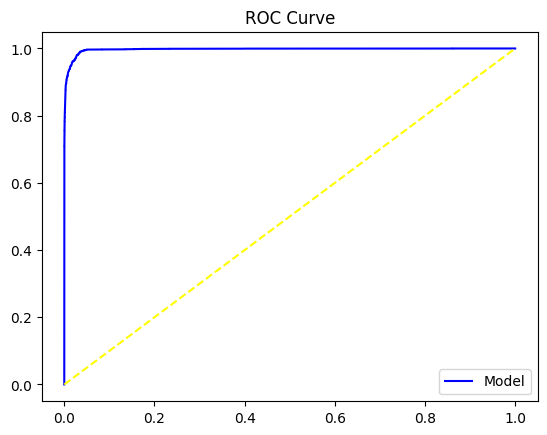

Accuracy 0.99
Precision: 0.96
Recall: 0.89
F1 Score 0.92
AUC: 0.9972123213415176


In [73]:
gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]
evaluate_model(y_train, y_pred_train, y_score_train)# performance with train data

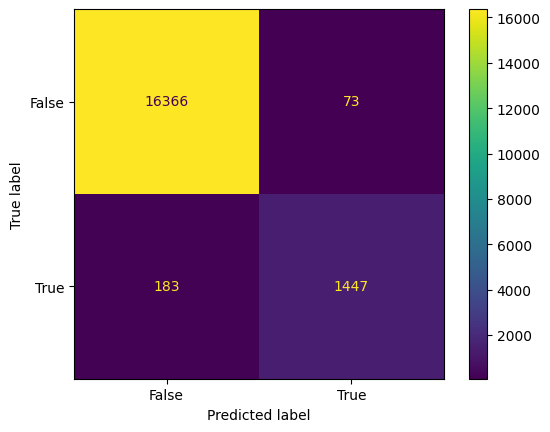

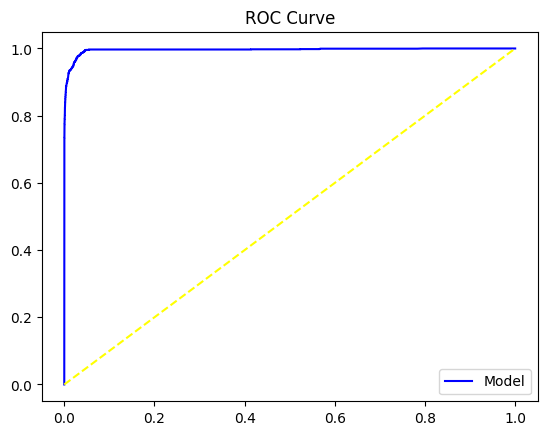

Accuracy 0.99
Precision: 0.95
Recall: 0.89
F1 Score 0.92
AUC: 0.9958812594768464


In [74]:
evaluate_model(y_test, y_pred_test, y_score_test) # performance with test data

## XGBoost model with undersampled dataset

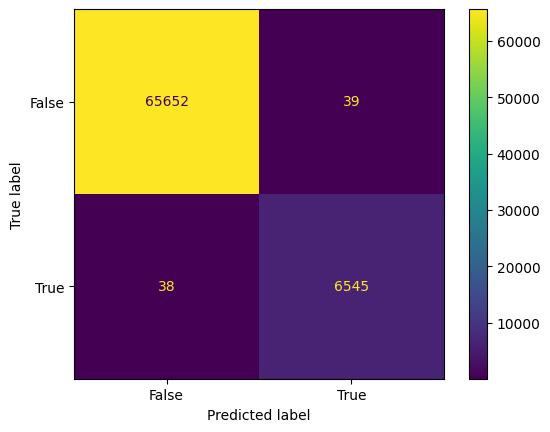

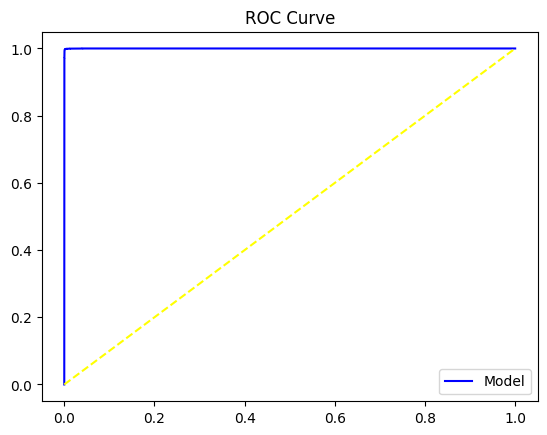

Accuracy 1.0
Precision: 0.99
Recall: 0.99
F1 Score 0.99
AUC: 0.9999621523120599


In [90]:
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
y_score_train = xgb.predict_proba(X_train)[:,1]

y_pred_test = xgb.predict(X_test)
y_score_test = xgb.predict_proba(X_test)[:,1]
evaluate_model(y_train, y_pred_train, y_score_train)# performance with train data

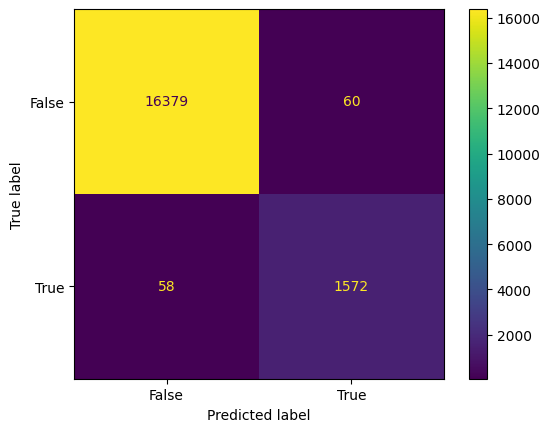

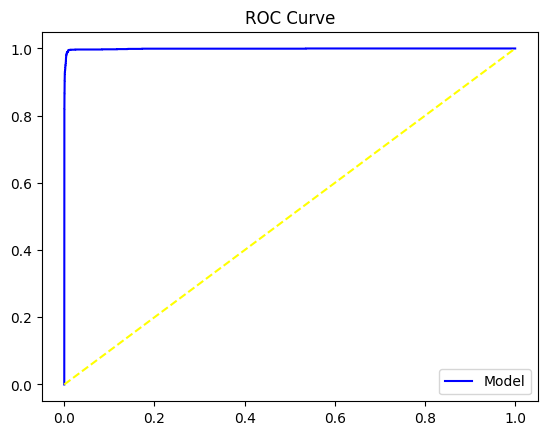

Accuracy 0.99
Precision: 0.96
Recall: 0.96
F1 Score 0.96
AUC: 0.998980689718487


In [91]:
evaluate_model(y_test, y_pred_test, y_score_test) # performance with test data

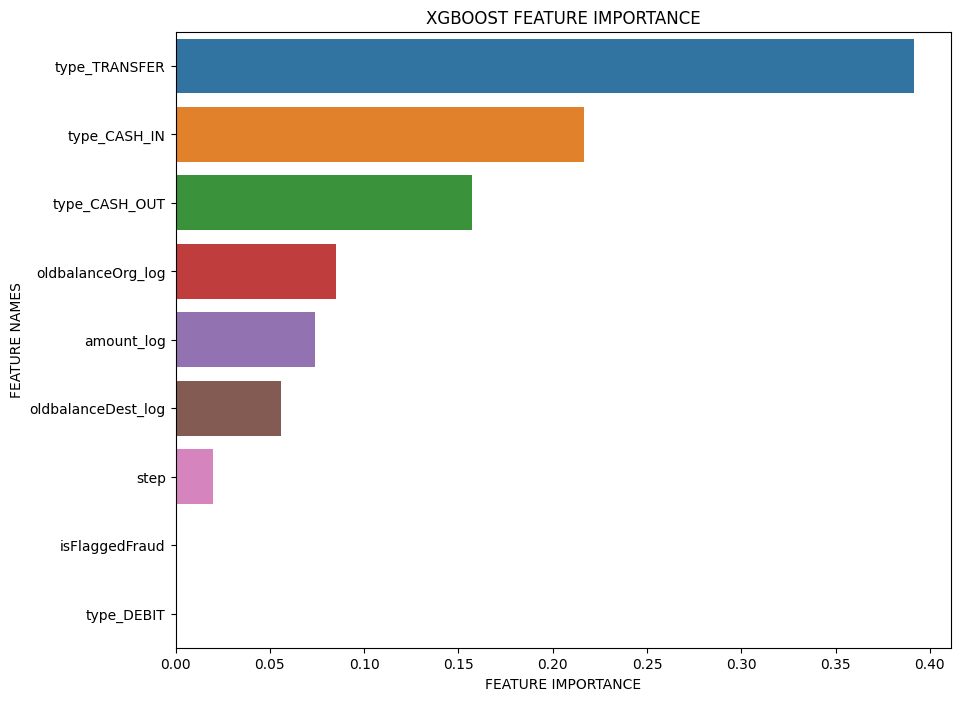

In [92]:
plot_feature_importance(xgb.feature_importances_,X_train.columns,'XGBOOST ')

In [93]:
# Splitting data into train and test sets for a oversampled dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7625288, 9) (1906322, 9) (7625288,) (1906322,)


# Decision Tree Classifier with XGBoost

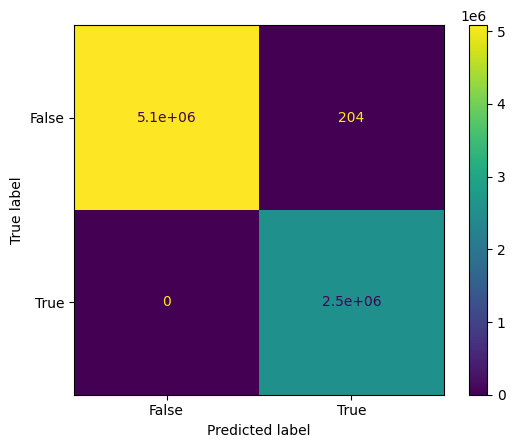

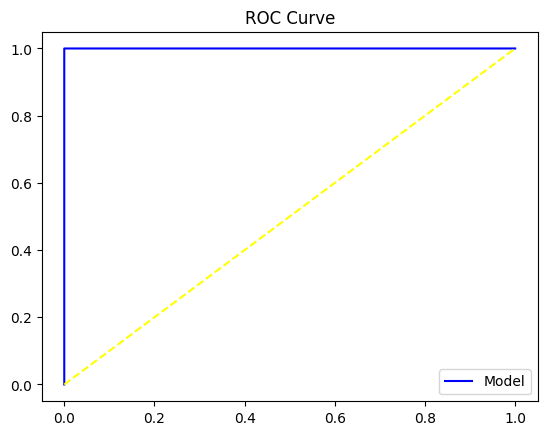

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 0.999999958114604


In [95]:
# Choosing xgb model because it has the best performance with undersampled data
# SO training xgb model with over sampled data as well
import xgboost as xgb
clf_xgb_g=xgb.XGBClassifier(n_jobs=-1,n_estimators=1000, random_state=23).fit(X_train, y_train)
y_pred_train = clf_xgb_g.predict(X_train)
y_score_train = clf_xgb_g.predict_proba(X_train)[:,1]

y_pred_test = clf_xgb_g.predict(X_test)
y_score_test = clf_xgb_g.predict_proba(X_test)[:,1]
evaluate_model(y_train, y_pred_train, y_score_train)

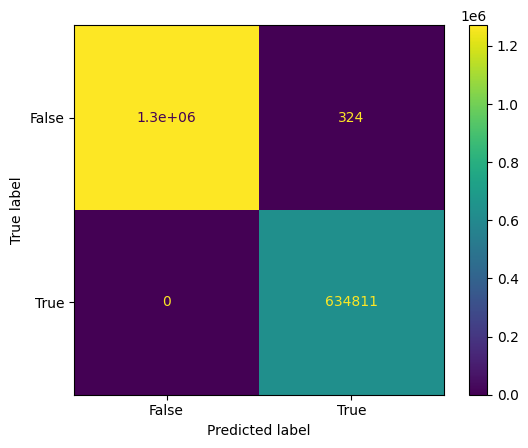

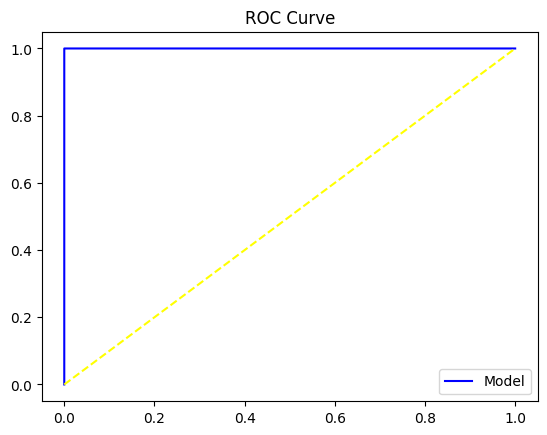

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 0.9999968279214606


In [96]:
evaluate_model(y_test, y_pred_test, y_score_test)

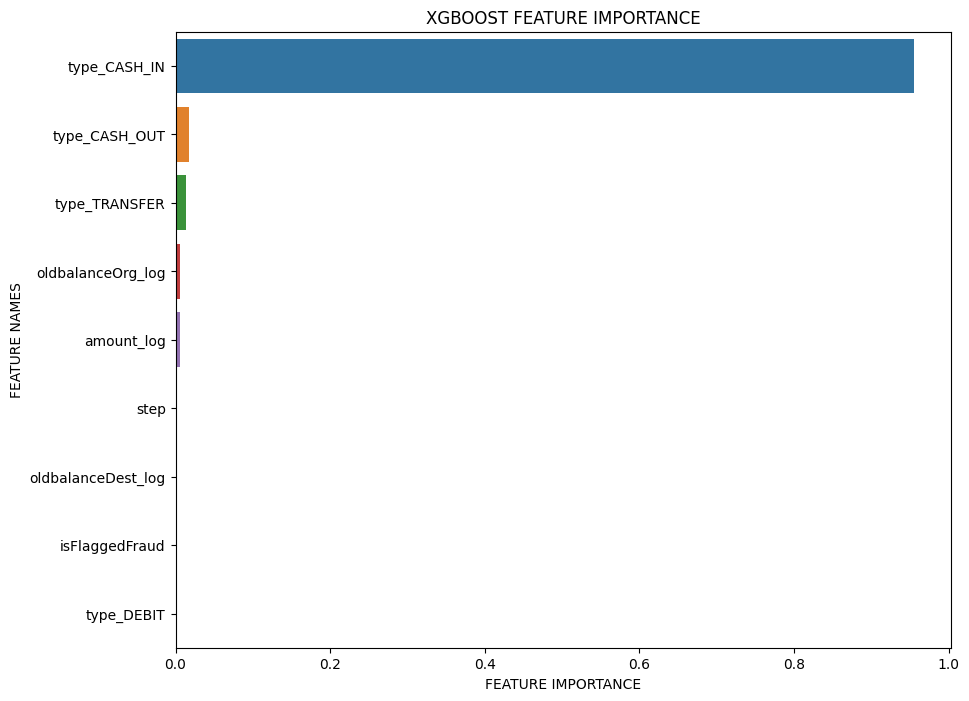

In [97]:
plot_feature_importance(clf_xgb_g.feature_importances_,X_train.columns,'XGBOOST ')

# Answers to questions in the PDF:






1.   Your views about the problem statement?

---


I felt that the problem statement was very interesting and could be further used in real world as well. The data did require a lot of pre processing and had extreme data points that could have been outliers. I had some confusion regarding the same and did my best to remove them.

2.  What will be your approach to solving this task?

---


I would like to work with neural networks to perform this task. Also using gradient descent might help the models.

3. What were the available ML model options you had to perform this task?

---


Logistic regression, LDA , KNN, Decision trees (Bagging and Boosting)

4. Which model’s performance is best and what could be the possible reason for that?

---


Out of all the models XGboost method followed by random forests performed the best. Unlike the other boosting method the ability of xgboost to regularize the trees created during boosting helps the method to avoid overfitting and to improve the genaralization ability of the final model.

5. What steps can you take to improve this selected model’s performance even further?

---


Increase the data size, experiment more with the parameters of the model and as mentioned before use new features to better improve the genaralization ability of the model.
